In [18]:
import CommonFunc
import pandas as pd

df = pd.read_csv('resources/co2_emmision_train_data.csv')
mask = df['CO2 Emissions (g/km)'] == 0
df = df[~mask]
df.drop_duplicates()

,Year,Make,Model,Vehicle Class,Engine Size (L),Cylinders,Transmission,Fuel Type,Fuel Consumption [City (L/100 km)],Fuel Consumption [Hwy (L/100 km)],...,Range 1 (km),Recharge Time (h),Fuel Type 2,Range 2 (km),Fuel Consumption [City (kWh/100 km)],Fuel Consumption [Comb (kWh/100 km)],Consumption [City (Le/100 km)],Consumption [Hwy (Le/100 km)],Consumption [Comb (Le/100 km)],Range (km)
0,2022.0,Acura,ILX,Compact,2.4,4.0,AM8,Z,9.9,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022.0,Acura,MDX SH-AWD,SUV: Small,3.5,6.0,AS10,Z,12.6,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022.0,Acura,MDX Type S,SUV: Standard,3.0,6.0,AS10,Z,13.8,11.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022.0,Acura,NSX,Two-seater,3.5,6.0,AM9,Z,11.1,10.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022.0,Acura,RDX SH-AWD,SUV: Small,2.0,4.0,AS10,Z,11.0,8.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26431,2022.0,Volvo,V60 T8 AWD Recharge Extended Range,Station wagon: Small,2.0,4.0,AS8,NaN,8.0,7.2,...,64.0,5.0,Z,792.0,NaN,NaN,NaN,NaN,NaN,NaN
26432,2022.0,Volvo,XC60 T8 AWD Recharge,SUV: Small,2.0,4.0,AS8,NaN,9.7,8.7,...,31.0,3.0,Z,769.0,NaN,NaN,NaN,NaN,NaN,NaN
26433,2022.0,Volvo,XC60 T8 AWD Recharge Extended Range,SUV: Small,2.0,4.0,AS8,NaN,8.5,8.5,...,58.0,5.0,Z,838.0,NaN,NaN,NaN,NaN,NaN,NaN
26434,2022.0,Volvo,XC90 T8 AWD Recharge,SUV: Standard,2.0,4.0,AS8,NaN,9.1,8.4,...,29.0,3.0,Z,813.0,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
#encoding categorical data
from sklearn.preprocessing import LabelEncoder


numdata = pd.DataFrame(df[['Year', 'Engine Size (L)', 'Cylinders', 'Fuel Consumption [Comb (L/100 km)]', 
                           'Fuel Consumption [Hwy (L/100 km)]', 'Fuel Consumption [City (L/100 km)]',
                           'CO2 Emissions (g/km)']])

label_encoder_1 = LabelEncoder()
label_encoder_2 = LabelEncoder()
label_encoder_3 = LabelEncoder()

vehicle_class = df[['Vehicle Class']].values.ravel()
fuel_type = df[['Fuel Type']].values.ravel()
transmission = df[['Transmission']].values.ravel()

encoded_vehicle_class = label_encoder_1.fit_transform(vehicle_class)
encoded_fuel_type = label_encoder_2.fit_transform(fuel_type)
encoded_transmission = label_encoder_3.fit_transform(transmission)

enc_1 = dict(zip(label_encoder_1.classes_,range(len(label_encoder_1.classes_))))
enc_2 = dict(zip(label_encoder_2.classes_,range(len(label_encoder_2.classes_))))
enc_3 = dict(zip(label_encoder_3.classes_,range(len(label_encoder_3.classes_))))

print(CommonFunc.printDict(enc_2))
print(CommonFunc.printDict(enc_3))

?   0
D   1
E   2
N   3
X   4
Z   5
nan   6

A1   0
A10   1
A3   2
A4   3
A5   4
A6   5
A7   6
A8   7
A9   8
AM5   9
AM6   10
AM7   11
AM8   12
AM9   13
AS10   14
AS4   15
AS5   16
AS6   17
AS7   18
AS8   19
AS9   20
AV   21
AV1   22
AV10   23
AV6   24
AV7   25
AV8   26
M4   27
M5   28
M6   29
M7   30



In [20]:
X_ = numdata[['Year', 'Engine Size (L)', 'Cylinders', 'Fuel Consumption [City (L/100 km)]', 
                           'Fuel Consumption [Hwy (L/100 km)]', 'Fuel Consumption [Comb (L/100 km)]']]
#X_['Vehicle Class'] = encoded_vehicle_class
X_['Transmission'] = encoded_fuel_type
X_['Fuel Type'] = encoded_transmission
feature_names = X_.columns
X=X_.values

y = numdata[['CO2 Emissions (g/km)']].values.ravel()

*****************
Метрики качества:
*****************
MAE: 0.3513068230
MSE: 3.3408165656
RMSE: 1.8277900770
R²: 0.9992635678


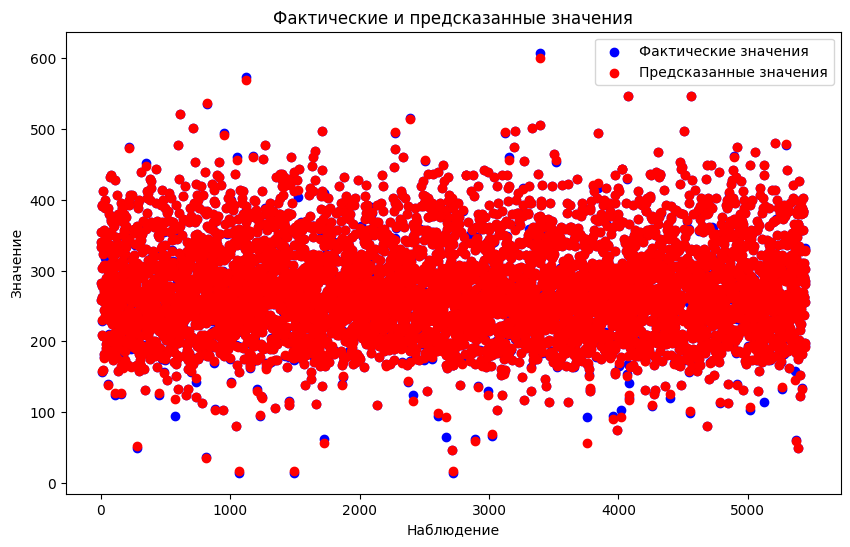

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\CommonFunc.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[indices], y=np.array(feature_names)[indices], palette='viridis')


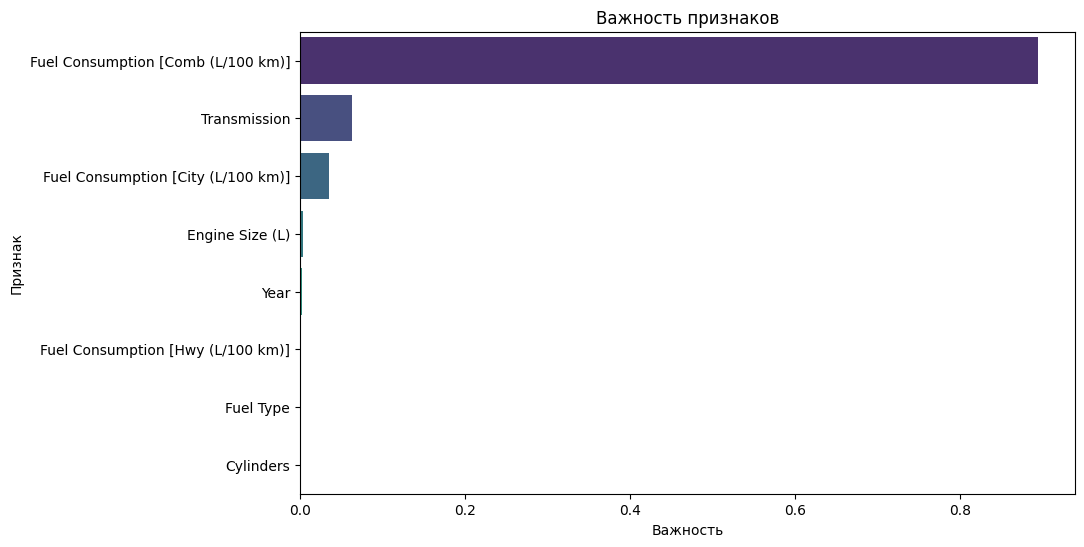

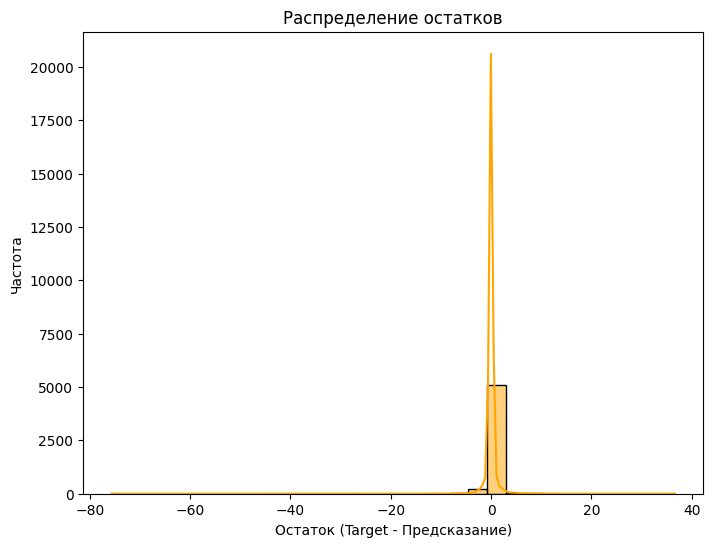

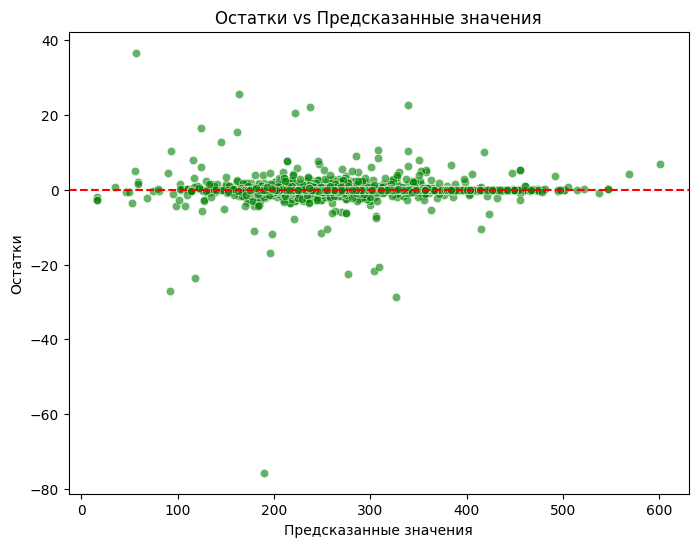

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rfr = RandomForestRegressor() # параметры
rfr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = rfr.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

# Важность признаков
CommonFunc.getImportances(rfr.feature_importances_, feature_names)

CommonFunc.getRemains(y_test, y_pred)


In [22]:
#дропаем не влияющие на результат колонки
X_ = X_.drop(columns=['Fuel Consumption [Hwy (L/100 km)]', 'Fuel Type', 'Cylinders'])
X=X_.values

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Best parameters found: {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}
*****************
Метрики качества:
*****************
MAE: 0.4461660049
MSE: 3.5854357890
RMSE: 1.8935246999
R²: 0.9992096452


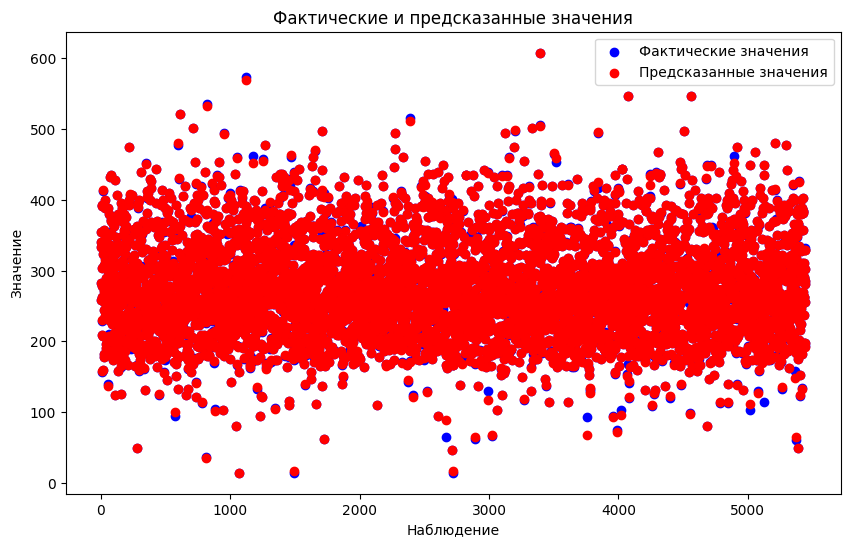

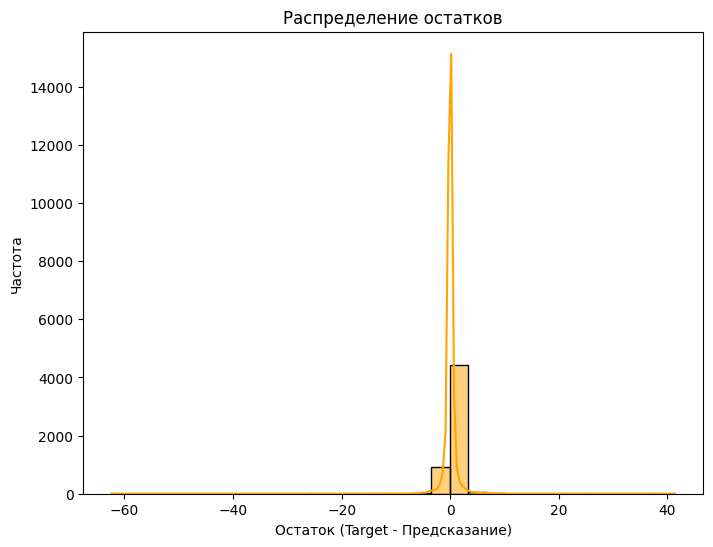

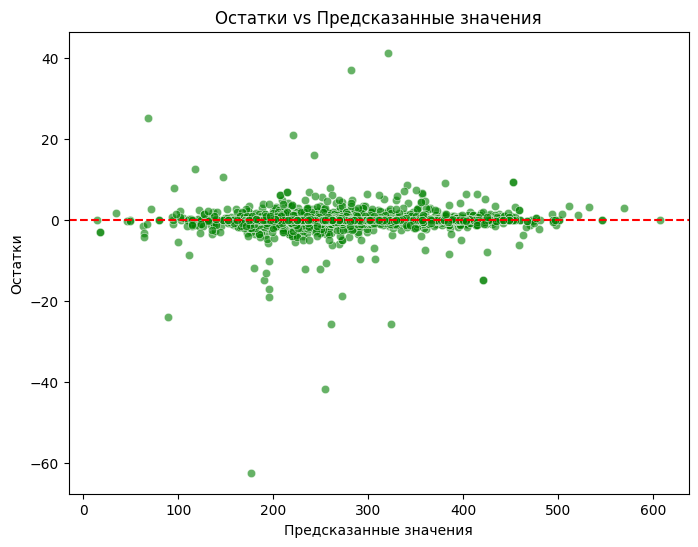

In [23]:
from sklearn.model_selection import GridSearchCV

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

In [24]:
#мой автомобиль (в реальности 149 - 191 г/км)
my_y = rfr.predict(((2004, 2.0, 0, 7.3, 4.5, 6.5, 0, 25),))
print(my_y) 

[154.9]


*****************
Метрики качества:
*****************
MAE: 2.0175961673
MSE: 12.2766290464
RMSE: 3.5038020844
R²: 0.9972938039


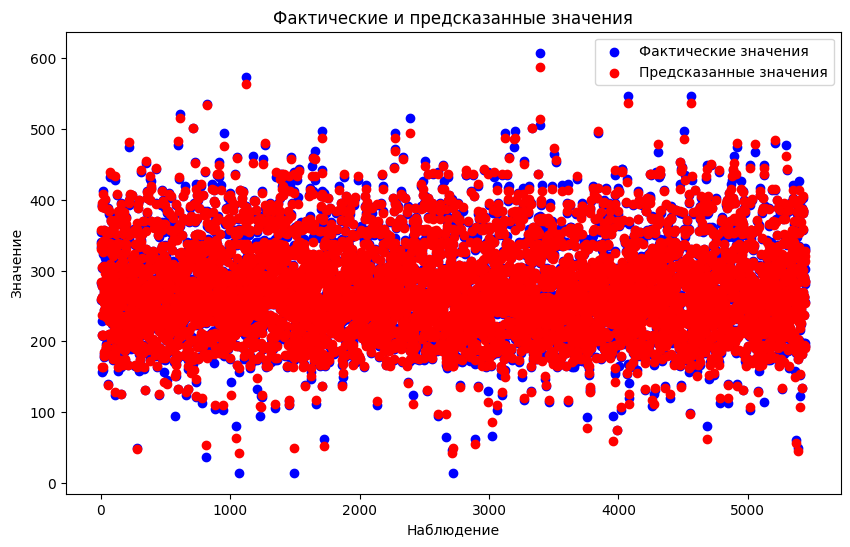

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor() # параметры
gbr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = gbr.predict(X_test)

# Вычисление метрик
gbr_metrics = CommonFunc.getMetrics(y_test, y_pred)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 525
[LightGBM] [Info] Number of data points in the train set: 21780, number of used features: 5
[LightGBM] [Info] Start training from score 274.856474
*****************
Метрики качества:
*****************
MAE: 0.9098351119
MSE: 8.2439888890
RMSE: 2.8712347325
R²: 0.9981827381


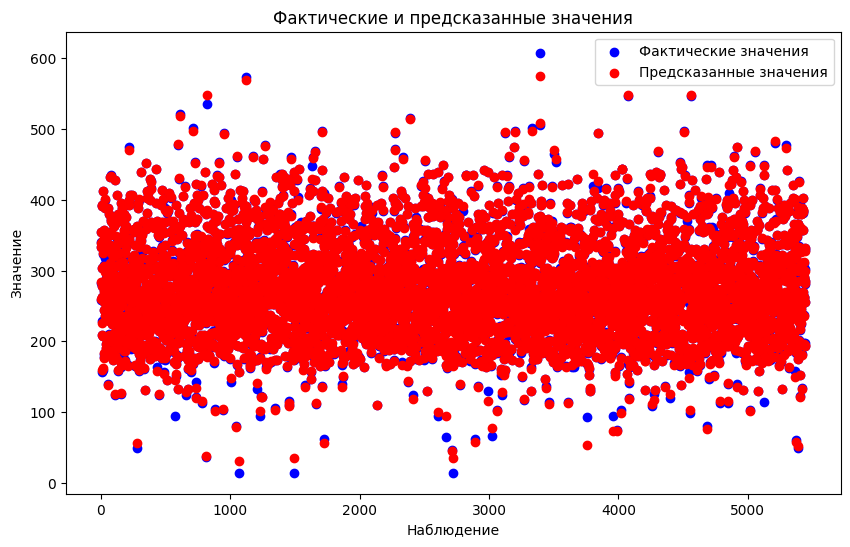

In [26]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor() # параметры
lgbm.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lgbm.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 0.5848736346
MSE: 4.7803943960
RMSE: 2.1864113053
R²: 0.9989462348


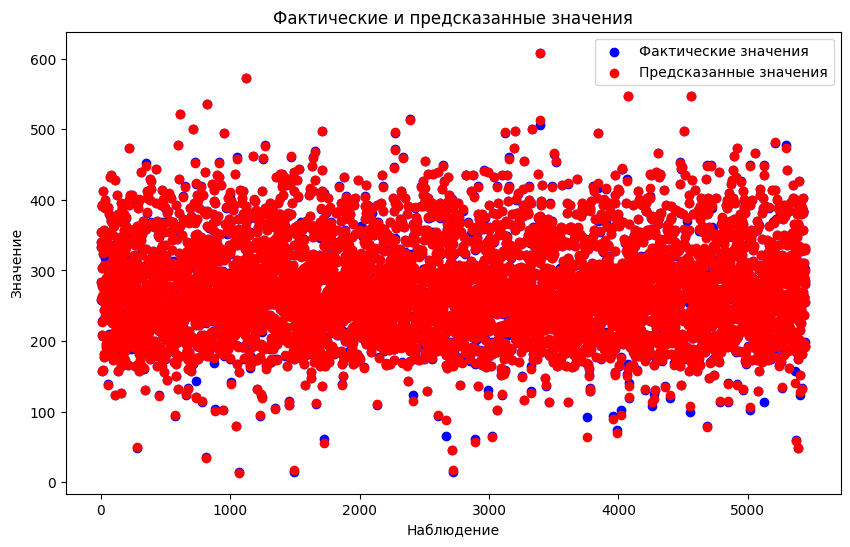

In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor() # параметры
xgb.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = xgb.predict(X_test)

# Вычисление метрик
lgbm_metrics = CommonFunc.getMetrics(y_test, y_pred)

C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
108 fits failed out of a total of 324.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5\hw5_venv\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\UserPc\Desktop\Новая папка\BHCourse_Homework_5

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
*****************
Метрики качества:
*****************
MAE: 8.8927950990
MSE: 496.9783688690
RMSE: 22.2930116599
R²: 0.8904486814


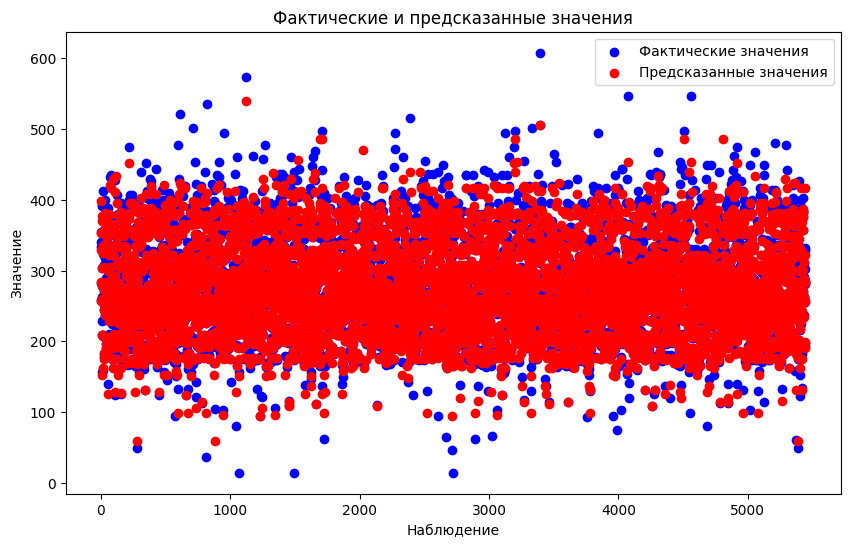

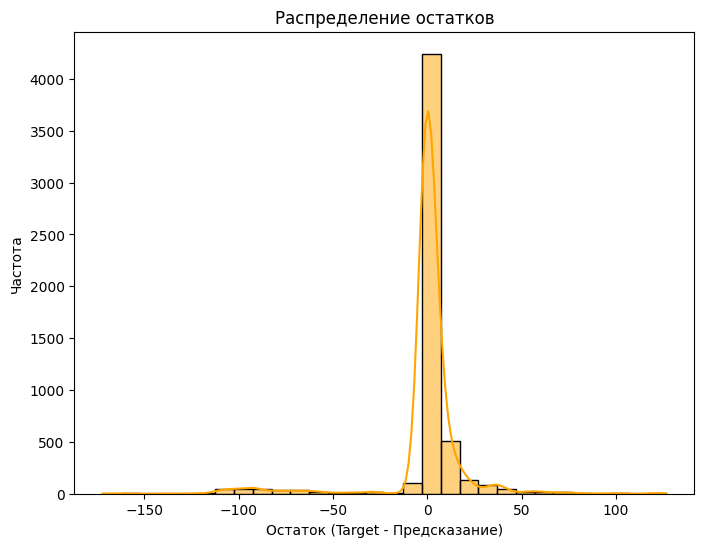

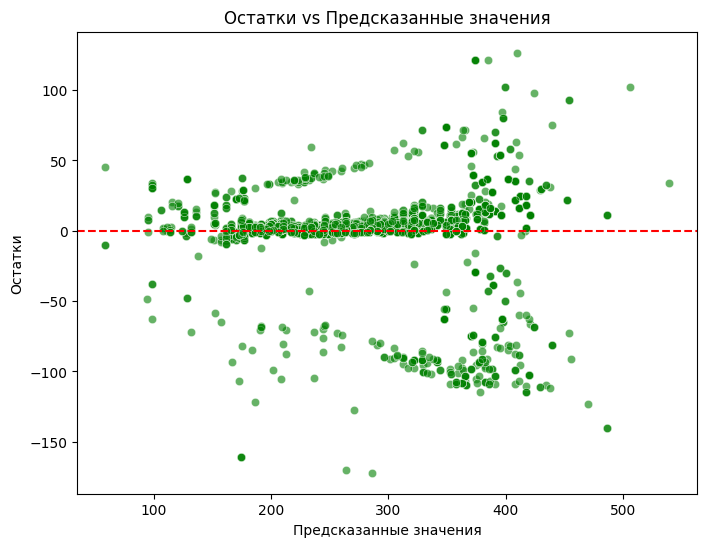

In [28]:
from sklearn.model_selection import GridSearchCV

X = numdata[['Fuel Consumption [Comb (L/100 km)]']]
y = numdata[['CO2 Emissions (g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [-1, 10, 20],
    'min_samples_split': [2, 8, 20],
    'max_features':[1, 'sqrt', 'log2'],
    'bootstrap':[True, False]
}
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2, scoring='neg_mean_squared_error')


grid_search.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search.best_params_
print(f'Best parameters found: {best_params}')

rfr_1 = RandomForestRegressor(**best_params) 
rfr_1.fit(X_train, y_train)
# Предсказание на тестовой выборке
y_pred = rfr_1.predict(X_test)

# Вычисление метрик
rfr_metrics = CommonFunc.getMetrics(y_test, y_pred)

CommonFunc.getRemains(y_test, y_pred)

*****************
Метрики качества:
*****************
MAE: 13.3579902665
MSE: 660.3812414682
RMSE: 25.6978839881
R²: 0.8544290047


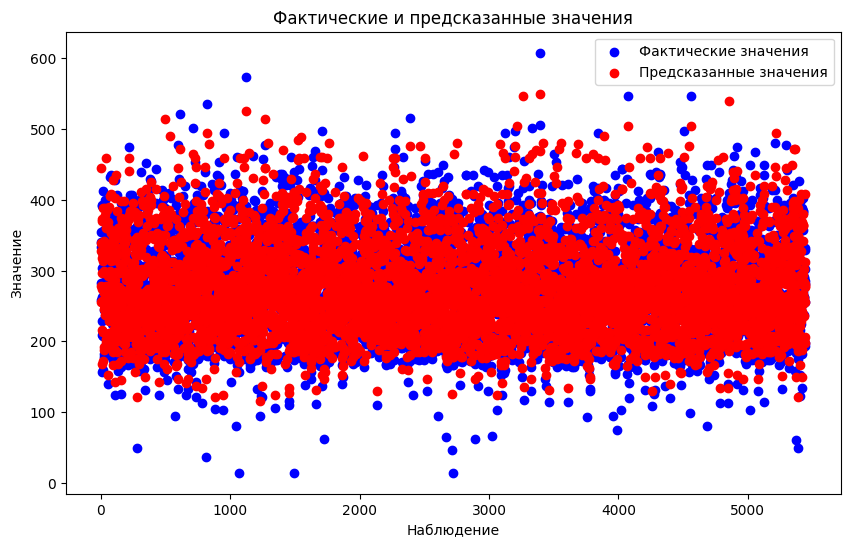

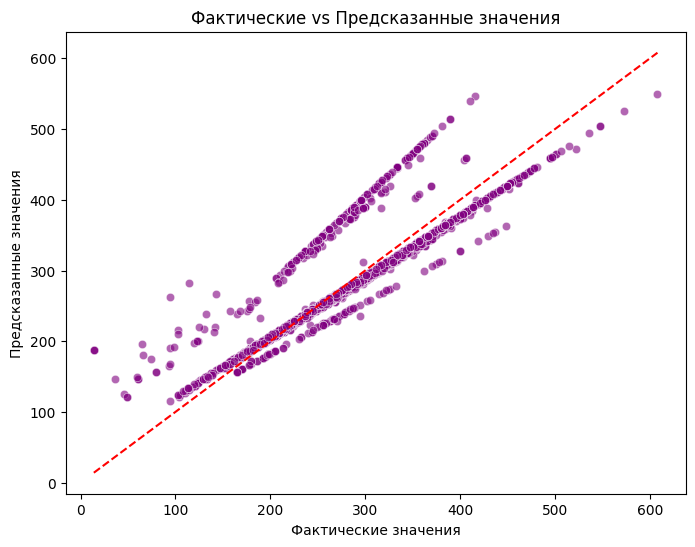

In [29]:
from sklearn.linear_model import LinearRegression

X = numdata[['Fuel Consumption [Comb (L/100 km)]']]
y = numdata[['CO2 Emissions (g/km)']].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor() 

lr = LinearRegression() 
lr.fit(X_train, y_train)

# Предсказание на тестовой выборке
y_pred = lr.predict(X_test)

# Вычисление метрик
lr_metrics = CommonFunc.getMetrics(y_test, y_pred)


# 12. Диаграмма предсказанных vs фактических значений
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='purple', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения')
plt.show()
